In [185]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import fftconvolve
%matplotlib widget

In [382]:
test_name = "bsanity/sanity"

In [398]:
# Read data from files

version = 0
em = pd.read_csv(f"../../data_tests/{test_name}/result/0.00T5.00_EM_v{version}.csv", skiprows=3)
sc = pd.read_csv(f"../../data_tests/{test_name}/result/0.00T5.00_SC_v{version}.csv", skiprows=3)
ac = sc # If we aren't taking autocorrelation every step
# ac = pd.read_csv("data/0.00T5.00_AC_v0.csv", skiprows=3)

In [399]:
# Extract numpy arrays from dataframes

temp = em["Temp"].to_numpy()

e_mean = em["E_mean"].to_numpy()
e_std = em["E_std"].to_numpy()
m_mean = em["M_mean"].to_numpy()
m_std = em["M_std"].to_numpy()

sc_data = np.empty((len(temp), len(sc.columns) - 2))
ac_data = np.empty((len(temp), len(sc.columns) - 2))

for idx, col_name in enumerate(sc.columns[1:-1]):
    sc_data[:, idx] = sc[col_name]
    
for idx, col_name in enumerate(ac.columns[1:-1]):
    ac_data[:, idx] = ac[col_name]
    
print(f"Test: {test_name}. {len(temp)} runs in {temp[0]} <= T <= {temp[-1]}")
print(f"temp.shape = {temp.shape}, sc_data.shape = {sc_data.shape}, ac_data.shape = {ac_data.shape}")

Test: bsanity/sanity. 500 runs in 0.0 <= T <= 4.99
temp.shape = (500,), sc_data.shape = (500, 49), ac_data.shape = (500, 49)


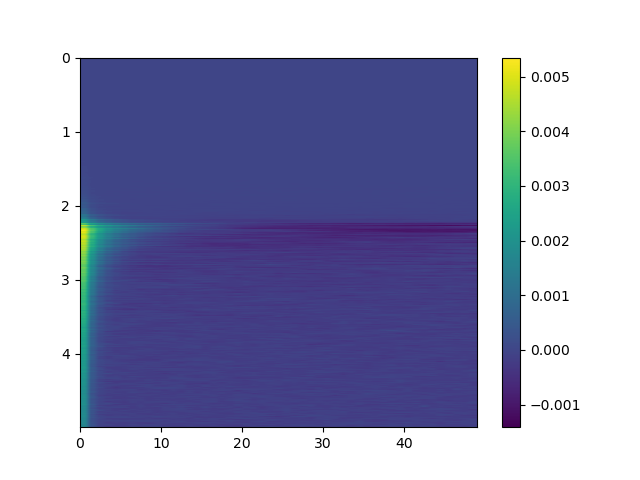

In [400]:
fig, ax = plt.subplots()
im = ax.imshow(sc_data, aspect="auto", extent=[0, sc_data.shape[1], temp[-1], temp[0]])
fig.colorbar(im)

In [401]:
decay = lambda x, A, xi : A * np.exp(- x / xi) if xi != 0 else A
A = np.empty_like(temp)
xi = np.empty_like(temp)
x = np.arange(sc_data.shape[1])

for i in np.arange(len(temp)):
    if np.abs(sc_data[i, :]).max() != 0:
        (val_A, val_xi), covm = curve_fit(decay, x, sc_data[i, :], p0=(sc_data[i, 0], 1e0))
    else:
        val_A, val_xi = 0, 0
    A[i] = val_A
    xi[i] = val_xi if np.abs(val_xi) < sc_data.shape[1] else 0
    

print(f"xi.shape = {xi.shape}, A.shape = {A.shape}")
print(f"xi.min = {xi.min()}, xi.max = {xi.max()}")

xi.shape = (500,), A.shape = (500,)
xi.min = 0.0, xi.max = 4.925862735389584


/var/folders/h6/326nqt2x2ql8ggvhjlhhckh40000gn/T/ipykernel_96479/3491209615.py:1: RuntimeWarning: overflow encountered in exp
  decay = lambda x, A, xi : A * np.exp(- x / xi) if xi != 0 else A
/Users/adrianhall/miniconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [402]:
winsize = 20
wincenter = winsize // 2
window = np.full(winsize, 1/winsize)
mav_xi = fftconvolve(xi, window, mode="same")
mvstd_xi = fftconvolve((xi - mav_xi)**2, window, mode="same")**0.5
mav_A = fftconvolve(A, window, mode="same")
mvstd_A = fftconvolve((A - mav_A)**2, window, mode="same")**0.5
mavdomain = slice(wincenter, -(wincenter - 1))
print(mav_xi.shape, mav_A.shape, mavdomain)

(500,) (500,) slice(10, -9, None)


/var/folders/h6/326nqt2x2ql8ggvhjlhhckh40000gn/T/ipykernel_96479/3302517732.py:5: RuntimeWarning: invalid value encountered in sqrt
  mvstd_xi = fftconvolve((xi - mav_xi)**2, window, mode="same")**0.5


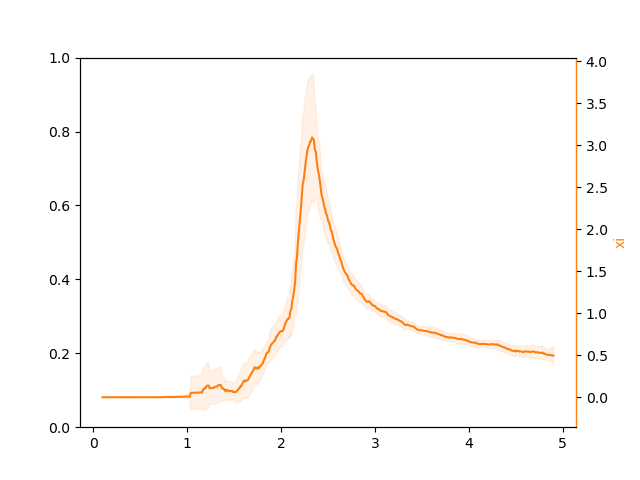

In [403]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
# ax.plot(temp[mavdomain], mav_A[mavdomain], label="A", color="tab:blue")
# ax.fill_between(temp[mavdomain], mav_A[mavdomain] + mvstd_A[mavdomain], mav_A[mavdomain] - mvstd_A[mavdomain], color="tab:blue", alpha=0.1)
# ax.yaxis.label.set_color("tab:blue")
# ax2.spines["left"].set_edgecolor("tab:blue")
# ax.set_ylabel("A")
ax2.plot(temp[mavdomain], mav_xi[mavdomain], label="xi", color="tab:orange")
ax2.fill_between(temp[mavdomain], mav_xi[mavdomain] + mvstd_xi[mavdomain], mav_xi[mavdomain] - mvstd_xi[mavdomain], color="tab:orange", alpha=0.1)
ax2.set_ylabel("xi")
ax2.yaxis.label.set_color("tab:orange")
ax2.spines["right"].set_edgecolor("tab:orange")

2.3000000000000003 3.384398532732046


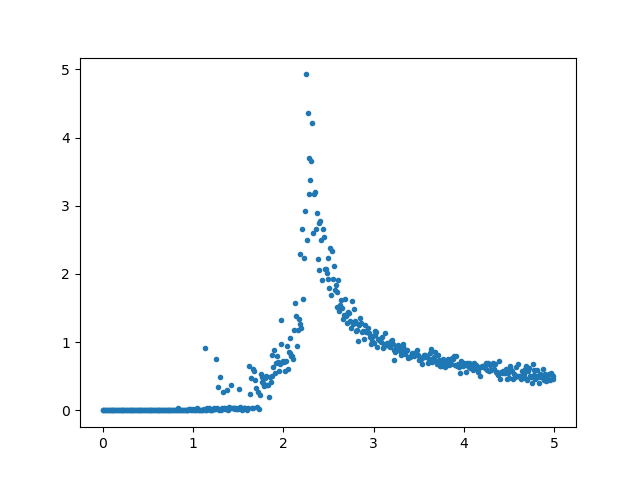

In [404]:
plt.close()
fig, ax = plt.subplots()
ax.scatter(temp, xi, marker=".")
print(temp[230], xi[230])

Test: bsanity/sanity. T = 2.26J, Fit = 2.72e-03exp(- x / 2.50)


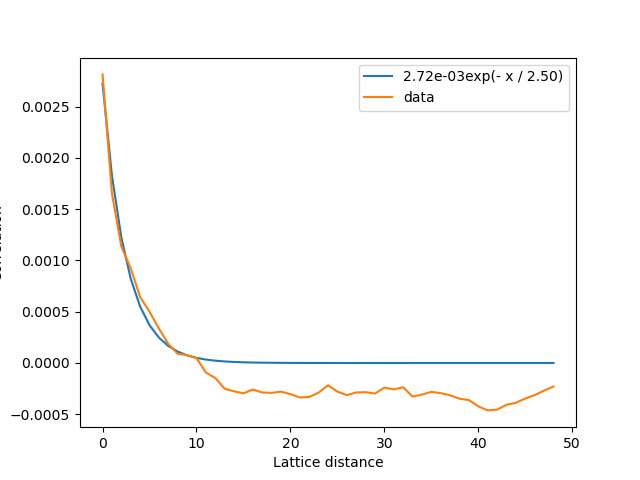

In [411]:
plt.close()
fig, ax = plt.subplots()
idx = temp.searchsorted(2.26)
#print(A[i], xi[i])
ax.plot(x, decay(x, A[idx], xi[idx]), label=f"{A[idx]:.2e}exp(- x / {xi[idx]:.2f})")
ax.plot(x, sc_data[idx], label="data")
ax.set_xlabel("Lattice distance")
ax.set_ylabel("Correlation")
# ax.plot(temp[tstart:tend], A, label="A")
# ax.plot(temp[tstart:tend], xi, label="xi")
ax.legend()
print(f"Test: {test_name}. T = {temp[idx]:.2f}J, Fit = {A[idx]:.2e}exp(- x / {xi[idx]:.2f})")

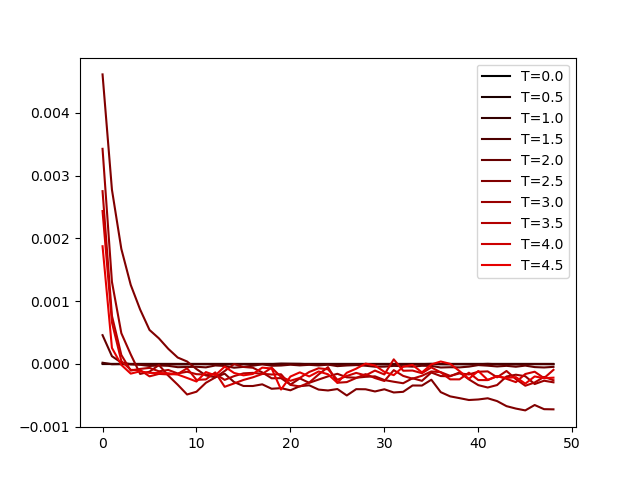

In [406]:


fig, ax = plt.subplots()
for i in np.arange(tstart, tend, (tend - tstart) // 10):
    ax.plot(sc_data[i, :], label=f"T={temp[i]}", color=(temp[i]/5, 0, 0))
    
ax.legend()